# Setup


In [1]:
# %%capture
# %pip install langchain==0.3.27
# %pip install jupyterlab==4.4.9

In [1]:
import os
import time
import uuid
import operator
from typing import TypedDict, Annotated
from dotenv import load_dotenv
from IPython.display import Image

__import__("pysqlite3")
import sys

sys.modules["sqlite3"] = sys.modules.pop("pysqlite3")

import pandas as pd

from langchain.embeddings import HuggingFaceEmbeddings
from langchain_core.tools import tool, create_retriever_tool
from langchain_core.messages import AnyMessage, AIMessage, SystemMessage, HumanMessage, ToolMessage
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_community.document_loaders import PyPDFLoader
from langchain_chroma import Chroma
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langgraph.prebuilt import create_react_agent
from langgraph.graph import StateGraph, END
from langgraph.checkpoint.memory import MemorySaver

/home/asdf/playground-agentic-ai/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
load_dotenv()

GOOGLE_API_KEY = os.environ["GOOGLE_API_KEY"]

In [3]:
# MODELS
model_gemini_2_0_flash = ChatGoogleGenerativeAI(
    model="gemini-2.0-flash",
    google_api_key=GOOGLE_API_KEY,
    temperature=0,
    max_tokens=100,
    max_retries=1,
)

# model_embedding_001 = GoogleGenerativeAIEmbeddings(
#     model="models/embedding-001", google_api_key=GOOGLE_API_KEY
# )

model_embedding_001 = HuggingFaceEmbeddings(
    model_name="all-MiniLM-L6-v2", model_kwargs={"device": "cpu"}
)

E0000 00:00:1760275581.973689    1978 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.
/tmp/ipykernel_1978/1986896818.py:14: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  model_embedding_001 = HuggingFaceEmbeddings(


# ReAct Agent Example


## Create agent


In [4]:
@tool
def find_sum(a: int, b: int) -> int:
    """
    Add two integers and return their sum.
    """
    return a + b


@tool
def find_product(a: int, b: int) -> int:
    """
    Multiply two integers and return their product.
    """
    return a * b

In [5]:
agent_tools = [find_sum, find_product]

system_prompt = SystemMessage(
    """
    You are a mathematician who solves math problems using tools only. 
    Do not solve any problem yourself — always use the available tools to find the solution.
    """
)

agent_graph = create_react_agent(
    model=model_gemini_2_0_flash, prompt=system_prompt, tools=agent_tools
)

## Invoke agent


In [6]:
# # Example 1
# inputs = {"messages": [("user", "what is the sum of 2 and 3 ?")]}
# result = agent_graph.invoke(inputs)

# print(f"Agent returned : {result['messages'][-1].content} \n")
# print("Step by Step execution : ")
# for message in result["messages"]:
#     print(message.pretty_repr())

In [7]:
# # Example 2
# inputs = {"messages": [("user", "What is 3 multipled by 2 and 5 + 1 ?")]}
# result = agent_graph.invoke(inputs)

# print(f"Agent returned : {result['messages'][-1].content} \n")
# print("Step by Step execution : ")
# for message in result["messages"]:
#     print(message.pretty_repr())

In [8]:
# # Example 3
# inputs = {"messages": [("user", "what is the sum of 2.1 and 3.7 ?")]}
# result = agent_graph.invoke(inputs)

# print(f"Agent returned : {result['messages'][-1].content} \n")
# print("Step by Step execution : ")
# for message in result["messages"]:
#     print(message.pretty_repr())

## Debug agent


In [9]:
agent_graph_debug = create_react_agent(
    model=model_gemini_2_0_flash, prompt=system_prompt, tools=agent_tools, debug=True
)

In [10]:
# inputs = {"messages": [("user", "what is the sum of 2 and 3 ?")]}
# result = agent_graph_debug.invoke(inputs)

# Product Q&A Chatbot


## Data


In [11]:
product_price_df = pd.read_csv("data/smartphone_prices.csv")
product_price_df

,Name,Price,ShippingDays
0,Zenith One,899,5
1,AeroPhone Lite,299,3
2,Photon X Ultra,1199,7
3,Nimbus Mini,749,4
4,Titan Max 5G,999,6


In [12]:
loader = PyPDFLoader("./data/smartphone_descriptions.pdf")
docs = loader.load()
docs

[Document(metadata={'producer': 'ReportLab PDF Library - www.reportlab.com', 'creator': '(unspecified)', 'creationdate': '2025-09-30T17:20:58+00:00', 'author': '(anonymous)', 'keywords': '', 'moddate': '2025-09-30T17:20:58+00:00', 'subject': '(unspecified)', 'title': '(anonymous)', 'trapped': '/False', 'source': './data/smartphone_descriptions.pdf', 'total_pages': 1, 'page': 0, 'page_label': '1'}, page_content='Zenith One\nThe Zenith One packs flagship performance into a slim design. It features the Snapdragon X3 chip,\n12GB of RAM, and 256GB of storage. Its 6.7-inch OLED display with 120Hz refresh rate delivers\nsmooth visuals, while the triple camera system excels in low-light photography.\n AeroPhone Lite\nAeroPhone Lite is designed for budget-conscious users who don’t want to compromise on quality.\nWith a MediaTek Helio G95 processor, 6GB RAM, and 128GB storage, it offers snappy\nperformance for everyday tasks. Its 5000mAh battery ensures two full days of usage.\n Photon X Ultra\n

## Tools


In [13]:
@tool
def get_smartphone_price(smartphone_name: str) -> int:
    """
    Returns the price of a smartphone by name (case-insensitive substring match).
    If no match is found, returns -1.
    """
    pattern = f"^{smartphone_name.strip()}"
    matches = product_price_df[
        product_price_df["Name"].str.contains(pattern, case=False, na=False)
    ]
    if matches.empty:
        return -1
    return int(matches["Price"].iloc[0])


print(get_smartphone_price.invoke("zenith"))
print(get_smartphone_price.invoke("asdf"))

899
-1


In [14]:
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1024, chunk_overlap=256)
splits = text_splitter.split_documents(docs)

feature_store = Chroma.from_documents(documents=splits, embedding=model_embedding_001)

get_product_features = create_retriever_tool(
    feature_store.as_retriever(search_kwargs={"k": 1}),
    name="Get_Product_Features",
    description="""
    This store contains details about smartphones. It lists the available smartphones
    and their features including camera, memory, storage, design and advantages
    """,
)

feature_store.as_retriever().invoke("Tell me about the Zenith One")

[Document(id='2ad39e4f-99c0-4251-96ce-2d61df104db5', metadata={'title': '(anonymous)', 'keywords': '', 'author': '(anonymous)', 'creationdate': '2025-09-30T17:20:58+00:00', 'page_label': '1', 'page': 0, 'subject': '(unspecified)', 'creator': '(unspecified)', 'total_pages': 1, 'source': './data/smartphone_descriptions.pdf', 'moddate': '2025-09-30T17:20:58+00:00', 'producer': 'ReportLab PDF Library - www.reportlab.com', 'trapped': '/False'}, page_content='Zenith One\nThe Zenith One packs flagship performance into a slim design. It features the Snapdragon X3 chip,\n12GB of RAM, and 256GB of storage. Its 6.7-inch OLED display with 120Hz refresh rate delivers\nsmooth visuals, while the triple camera system excels in low-light photography.\n AeroPhone Lite\nAeroPhone Lite is designed for budget-conscious users who don’t want to compromise on quality.\nWith a MediaTek Helio G95 processor, 6GB RAM, and 128GB storage, it offers snappy\nperformance for everyday tasks. Its 5000mAh battery ensures

## Chatbot

In [15]:
system_prompt = SystemMessage(
    """
    You are professional chatbot that answers questions about smartphones sold by your company.
    To answer questions about smartphones, you will ONLY use the available tools and NOT your own memory.
    You will handle small talk and greetings by producing professional responses.
    """
)
checkpointer = MemorySaver()  # conversation memory

product_QnA_agent = create_react_agent(
    model=model_gemini_2_0_flash,
    tools=[get_smartphone_price, get_product_features],
    prompt=system_prompt,
    debug=False,
    checkpointer=checkpointer,
)

In [16]:
# # To maintain memory, each request should be in the context of a thread.
# # Each user conversation will use a separate thread ID
# config = {"configurable": {"thread_id": uuid.uuid4()}}

# inputs = {
#     "messages": [HumanMessage("What are the features and pricing for Zenith One?")]
# }

# # Use streaming to print responses as the agent  does the work.
# # This is an alternate way to stream agent responses without waiting for the agent to finish
# for stream in product_QnA_agent.stream(inputs, config, stream_mode="values"):
#     message = stream["messages"][-1]
#     if isinstance(message, tuple):
#         print(message)
#     else:
#         message.pretty_print()

## Execute

In [17]:
# # This simulates the conversation between the user and the Agentic chatbot
# user_inputs = [
#     "Hello",
#     "I am looking to buy a smartphone",
#     "Give me a list of available smartphone names",
#     "Tell me about the features of Zenith One",
#     "How much does it cost?",
#     "Give me similar information about TitanMax",
#     "What info do you have on Nimbus ?",
#     "Thanks for the help",
# ]

# # Create a new thread
# config = {"configurable": {"thread_id": str(uuid.uuid4())}}

# for input in user_inputs:
#     time.sleep(1)
#     print(f"----------------------------------------\nUSER : {input}")
#     user_message = {"messages": [HumanMessage(input)]}
#     ai_response = product_QnA_agent.invoke(user_message, config=config)
#     print(f"AGENT : {ai_response['messages'][-1].content}")

In [18]:
# # conversation memory by user
# def execute_prompt(user, config, prompt):
#     inputs = {"messages": [("user", prompt)]}
#     ai_response = product_QnA_agent.invoke(inputs, config=config)
#     print(f"\n{user}: {ai_response['messages'][-1].content}")


# # Create different session threads for 2 users
# config_1 = {"configurable": {"thread_id": str(uuid.uuid4())}}
# config_2 = {"configurable": {"thread_id": str(uuid.uuid4())}}

# # Test both threads
# execute_prompt("USER 1", config_1, "Tell me about the features of  Zenith")
# execute_prompt("USER 2", config_2, "Tell me about the features of Nimbus Mini")
# execute_prompt("USER 1", config_1, "What is its price ?")
# execute_prompt("USER 2", config_2, "What is its price ?")

# Orders Chatbot

## Data

In [19]:
product_orders_df = pd.read_csv("data/smartphone_orders.csv")
product_orders_df

,Order ID,Product Ordered,Quantity Ordered,Delivery Date
0,ORD-5821,Zenith One,2,2024-10-12
1,ORD-9022,Titan Max 5G,5,2024-10-30
2,ORD-7365,Zenith One,3,2024-10-22
3,ORD-8510,Nimbus Mini,2,2024-10-26
4,ORD-6947,AeroPhone Lite,1,2024-10-18


## Tools

In [20]:
@tool
def get_order_details(order_id: str) -> str:
    """
    This function returns details about a smartphone order, given an order ID
    It performs an exact match between the input order id and available order ids
    If a match is found, it returns products (smartphones) ordered, quantity ordered and delivery date.
    If there is NO match found, it returns -1
    """
    matches = product_orders_df[product_orders_df["Order ID"] == order_id]

    if matches.empty:
        return -1
    else:
        return matches.iloc[0].to_dict()


print(get_order_details.invoke("ORD-5821"))
print(get_order_details.invoke("ORD-8510"))

{'Order ID': 'ORD-5821', 'Product Ordered': 'Zenith One', 'Quantity Ordered': 2, 'Delivery Date': '2024-10-12'}
{'Order ID': 'ORD-8510', 'Product Ordered': 'Nimbus Mini', 'Quantity Ordered': 2, 'Delivery Date': '2024-10-26'}


In [21]:
@tool
def update_quantity(order_id: str, new_quantity: int) -> bool:
    """
    This function updates the quantity of products (smartphones) ordered for a given order Id.
    It there are no matching orders, it returns -1.
    """
    matches = product_orders_df[product_orders_df["Order ID"] == order_id]

    if matches.empty:
        return -1
    else:
        product_orders_df.loc[
            product_orders_df["Order ID"] == order_id, "Quantity Ordered"
        ] = new_quantity
        return True

In [22]:
# # to test comment out @tool decorator
# print(get_order_details("ORD-5821"))
# print(update_quantity("ORD-5821", 20))
# print(get_order_details("ORD-9022"))
# print(update_quantity("ORD-9022", 50))
# product_orders_df

## Chatbot

In [23]:
# An Agent State class that keeps the state of the agent while it answers a query
class OrdersAgentState(TypedDict):
    messages: Annotated[list[AnyMessage], operator.add]


# An Agent class
class OrdersAgent:

    def __init__(self, model, tools, system_prompt, debug):

        self.system_prompt = system_prompt
        self.debug = debug

        # Setup the graph for the agent manually
        agent_graph = StateGraph(OrdersAgentState)
        agent_graph.add_node("orders_llm", self.call_llm)
        agent_graph.add_node("orders_tools", self.call_tools)
        agent_graph.add_conditional_edges(
            "orders_llm", self.is_tool_call, {True: "orders_tools", False: END}
        )
        agent_graph.add_edge("orders_tools", "orders_llm")
        agent_graph.set_entry_point("orders_llm")
        self.memory = MemorySaver()  # chat memory
        self.agent_graph = agent_graph.compile(
            checkpointer=self.memory
        )  # compile the graph

        # Setup tools
        self.tools = {tool.name: tool for tool in tools}
        if self.debug:
            print("\nTools loaded :", self.tools)
        self.model = model.bind_tools(tools)  # attach tools to model

    # Call the LLM with the messages to get next action/result
    def call_llm(self, state: OrdersAgentState):

        messages = state["messages"]
        if self.system_prompt:
            messages = [SystemMessage(content=self.system_prompt)] + messages

        result = self.model.invoke(
            messages
        )  # invoke the model with the message history
        if self.debug:
            print(f"\nLLM Returned : {result}")

        return {"messages": [result]}  # Return the LLM output

    # Check if the next action is a tool call.
    def is_tool_call(self, state: OrdersAgentState):
        last_message = state["messages"][-1]
        if len(last_message.tool_calls) > 0:
            return True
        else:
            return False

    # Execute the tool requested with the given parameters
    def call_tools(self, state: OrdersAgentState):
        tool_calls = state["messages"][-1].tool_calls
        results = []

        for tool in tool_calls:
            # Handle tool missing error
            if not tool["name"] in self.tools:
                print(f"Unknown tool name {tool}")
                result = "Invalid tool found. Please retry"
            else:
                result = self.tools[tool["name"]].invoke(tool["args"])

            # append results to the list of tool results
            results.append(
                ToolMessage(
                    tool_call_id=tool["id"], name=tool["name"], content=str(result)
                )
            )

            if self.debug:
                print(f"\nTools returned {results}")
            # return tool results
            return {"messages": results}

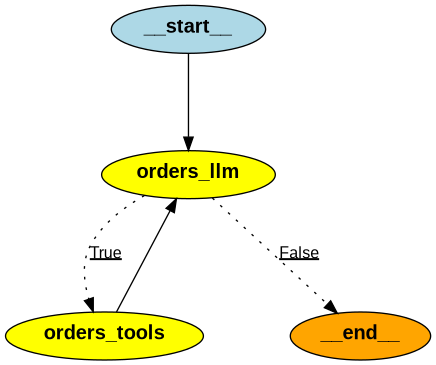

In [24]:
system_prompt = """
    You are professional chatbot that manages orders for smartphones sold by our company.
    The tools allow for retrieving order details as well as update order quantity.
    Do NOT reveal information about other orders than the one requested.
    You will handle small talk and greetings by producing professional responses.
    """

orders_agent = OrdersAgent(
    model_gemini_2_0_flash,
    [get_order_details, update_quantity],
    system_prompt,
    debug=False,
)

# Visualize the Agent
Image(orders_agent.agent_graph.get_graph().draw_png())

## Execute

In [25]:
# user_inputs = [
#     "How are you doing?",
#     "Please show me the details of the order ORD-5821",
#     "Can you add one more of that laptop to the order? ",
#     "Can you show me the details again ? ",
#     "What about order ORD-9999 ?",
#     "Bye",
# ]

# config = {"configurable": {"thread_id": str(uuid.uuid4())}}  # create a new thread

# for input in user_inputs:
#     print(f"----------------------------------------\nUSER : {input}")
#     user_message = {"messages": [HumanMessage(input)]}  # format the user message
#     ai_response = orders_agent.agent_graph.invoke(
#         user_message, config=config
#     )  # get response from the agent
#     print(f"\nAGENT : {ai_response['messages'][-1].content}")

# Reflection-based Summary Agent

In [26]:
summarizer_prompt = """
You are a document summarizer. 
Summarize the provided text in fewer than 50 words. 
If feedback or critique is given, revise your previous summary based on that input.
"""


reviewer_prompt = """
You are a reviewer evaluating summaries of a document. 
Compare the original text with the generated summary. 
Assess its accuracy and completeness, and give improvement suggestions in fewer than 50 words.
"""

In [27]:
class SummaryAgentState(TypedDict):
    messages: Annotated[list[AnyMessage], operator.add]


class SummaryAgent:

    def __init__(self, model, summarizer_prompt, reviewer_prompt, debug):
        self.model = model
        self.summarizer_prompt = summarizer_prompt
        self.reviewer_prompt = reviewer_prompt
        self.debug = debug

        # Setup the graph for the agent manually
        agent_graph = StateGraph(SummaryAgentState)
        agent_graph.add_node("summarizer", self.generate_summary)
        agent_graph.add_node("reviewer", self.review_summary)
        agent_graph.add_conditional_edges(
            "summarizer", self.should_continue, {True: "reviewer", False: END}
        )
        agent_graph.add_edge("reviewer", "summarizer")
        agent_graph.set_entry_point("summarizer")
        self.memory = MemorySaver()  # chat memory
        self.agent_graph = agent_graph.compile(
            checkpointer=self.memory
        )  # compile the graph
        self.iteration = 1

    def generate_summary(self, state: SummaryAgentState):
        messages = state["messages"]
        messages = [SystemMessage(content=self.summarizer_prompt)] + messages

        # Invoke summarizer with the message history
        result = self.model.invoke(messages)

        if self.debug:
            print(
                f"==============\nSummarizer output:\n{result.content}\n==============\n"
            )
        # tagged_result = AIMessage(content=f"[SUMMARY]\n{result.content}")
        return {"messages": [result]}

    def review_summary(self, state: SummaryAgentState):
        messages = state["messages"]
        messages = [SystemMessage(content=self.reviewer_prompt)] + messages

        # Invoke reviewer with the message history
        result = self.model.invoke(messages)

        if self.debug:
            print(f"*************\nReviewer output:\n{result.content}\n*************\n")
        # tagged_result = AIMessage(content=f"[REVIEW]\n{result.content}")
        return {"messages": [result]}

    def should_continue(self, _: SummaryAgentState):

        if self.debug:
            print(f"Iteration number: {self.iteration}\n")

        # Stop after 2 iterations
        if self.iteration > 2:
            return False
        self.iteration += 1
        return True

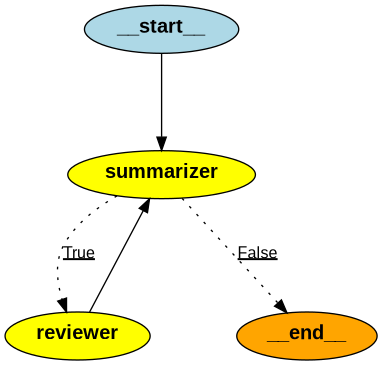

In [28]:
summary_chatbot = SummaryAgent(
    model_gemini_2_0_flash, summarizer_prompt, reviewer_prompt, debug=True
)

Image(summary_chatbot.agent_graph.get_graph().draw_png())

In [29]:
loader = PyPDFLoader("./data/renewable_energy.pdf")
docs = loader.load()
source_content = docs[0].page_content.replace("\n", " ")
print(source_content)

The  global  transition  toward  renewable  energy  is  gaining  momentum  as  nations  seek  to   reduce   their   dependence   on   fossil   fuels   and   address   the   escalating   threats   of   climate   change.   Renewable   energy   sources—such   as   solar,   wind,   hydroelectric,   and   geothermal   power—are   being   increasingly   embraced   due   to   their   sustainability,   lower   greenhouse   gas   emissions,   and   long-term   economic   benefits.   Among   these,   solar   and   wind   energy   have   experienced   the   most   significant   growth   over   the   past   decade,   fueled   by   rapid   technological   advancements,   declining   costs,   and   supportive   government   incentives.   Solar  energy,  for  example,  has  become  far  more  accessible  thanks  to  improvements  in   photovoltaic   cell   efficiency   and   a   decrease   in   manufacturing   costs.   Rooftop   solar   panels   are   now   common   in   both   urban   and   rural   

In [30]:
# config = {"configurable": {"thread_id": str(uuid.uuid4())}}

# messages = [HumanMessage(content=source_content)]
# result = summary_chatbot.agent_graph.invoke({"messages": messages}, config)

In [31]:
# summary_chatbot = SummaryAgent(
#     model_gemini_2_0_flash, summarizer_prompt, reviewer_prompt, debug=False
# )


# user_inputs = [
#     source_content,
#     "Can you rewrite the review making it more scientific?",
#     "Can you make it even shorter?",
# ]

# # Create a new thread
# config = {"configurable": {"thread_id": str(uuid.uuid4())}}

# # Given the number of iterations, this will take a long time.
# for input in user_inputs:
#     print(f"============================================\nUSER:\n{input}")
#     # Format the user message
#     user_message = {"messages": [HumanMessage(input)]}
#     # Get response from the agent
#     ai_response = summary_chatbot.agent_graph.invoke(user_message, config=config)
#     # Print the response
#     print(f"\nAGENT:")
#     summary = ai_response["messages"][-1].content
#     if not summary:
#         summary = ai_response["messages"][-3].content
#     print(summary)
#     # for m in ai_response['messages']:
#     #     print(m.type)
#     #     print(m.content)
#     #     print("--------------------------------------------")

# Routing-based Multiagent Chantbot

In [32]:
import functools


def agent_node(state, agent, name, config):
    """Helper function to invoke an agent"""

    # Extract thread id from request for conversation memory
    thread_id = config["metadata"]["thread_id"]
    # Set the config for calling the agent
    agent_config = {"configurable": {"thread_id": thread_id}}
    # Invoke the agent with the state
    result = agent.invoke(state, agent_config)

    # Convert the agent output into a format that is suitable to append to the global state
    if isinstance(result, ToolMessage):
        pass
    else:
        final_result = AIMessage(result["messages"][-1].content)
    return {"messages": [final_result]}


product_QnA_node = functools.partial(
    agent_node, agent=product_QnA_agent, name="Product_QnA_Agent"
)
orders_node = functools.partial(
    agent_node, agent=orders_agent.agent_graph, name="Orders_Agent"
)
# nodes are partially intialized and need only state and config

In [ ]:
class RouterAgentState(TypedDict):
    messages: Annotated[list[AnyMessage], operator.add]


class RouterAgent:

    def __init__(self, model, system_prompt, smalltalk_prompt, debug=False):

        self.system_prompt = system_prompt
        self.smalltalk_prompt = smalltalk_prompt
        self.model = model
        self.debug = debug

        router_graph = StateGraph(RouterAgentState)
        router_graph.add_node("Router", self.call_llm)
        router_graph.add_node("Product_Agent", product_QnA_node)
        router_graph.add_node("Orders_Agent", orders_node)
        router_graph.add_node("Small_Talk", self.respond_smalltalk)

        router_graph.add_conditional_edges(
            "Router",
            self.find_route,
            {
                "PRODUCT": "Product_Agent",
                "ORDER": "Orders_Agent",
                "SMALLTALK": "Small_Talk",
                "END": END,
            },
        )
        router_graph.add_edge("Product_Agent", END)
        router_graph.add_edge("Orders_Agent", END)
        router_graph.add_edge("Small_Talk", END)
        router_graph.set_entry_point("Router")
        self.router_graph = router_graph.compile()

    def call_llm(self, state: RouterAgentState):

        messages = state["messages"]
        if self.debug:
            print(f"Call LLM received {messages}")

        result = self.model.invoke(
            [SystemMessage(content=self.system_prompt)] + messages
            if self.system_prompt
            else messages
        )
        if self.debug:
            print(f"Call LLM result {result}")

        return {"messages": [result]}

    def respond_smalltalk(self, state: RouterAgentState):

        messages = state["messages"]
        if self.debug:
            print(f"Small talk received: {messages}")

        result = self.model.invoke(
            [SystemMessage(content=self.system_prompt)] + messages
            if self.system_prompt
            else messages
        )
        if self.debug:
            print(f"Small talk result: {result}")

        return {"messages": [result]}

    def find_route(self, state: RouterAgentState):
        last_message = state["messages"][-1]
        if self.debug:
            print("Router: Last result from LLM : ", last_message)

        destination = last_message.content
        if self.debug:
            print(f"Destination chosen : {destination}")
        return destination

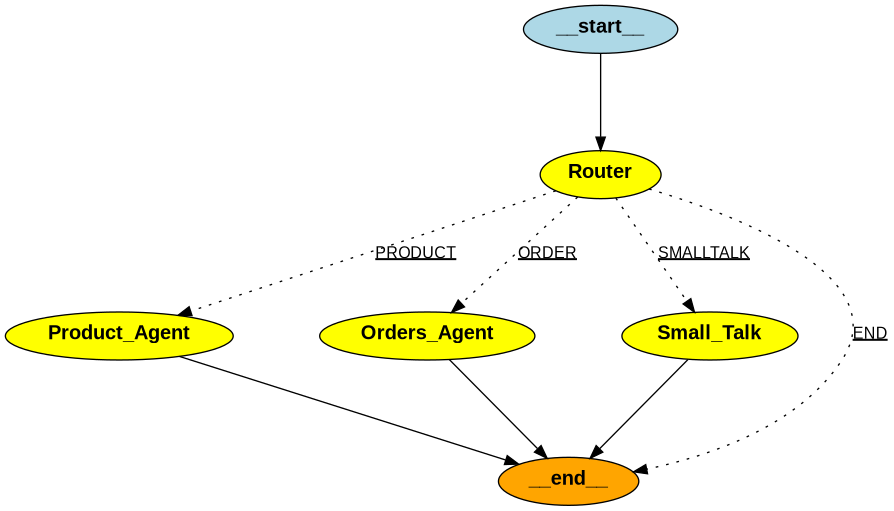

In [34]:
system_prompt = """
You are a Router. Analyze the user's query and classify it into one of four categories:

SMALLTALK — Greetings, farewells, or casual conversation.
PRODUCT — Questions about laptop features, specifications, or pricing.
ORDER — Questions about laptop orders, including status, details, or updates.
END — None of the above.

Respond with exactly one of these words: SMALLTALK, PRODUCT, ORDER, or END.
"""

smalltalk_prompt = """
You are a polite assistant for a laptop retailer.
If the user greets you or makes small talk, respond briefly and professionally.
Mention that you can also answer questions about laptop products and help with order status or updates.
"""

router_agent = RouterAgent(model_gemini_2_0_flash, system_prompt, smalltalk_prompt, debug=False)

Image(router_agent.router_graph.get_graph().draw_png())

In [35]:
messages = [HumanMessage(content="Tell me about the features of Nimbus Mini")]
config = {"configurable": {"thread_id": str(uuid.uuid4())}}
result = router_agent.router_graph.invoke({"messages": messages}, config)
for message in result["messages"]:
    print(message.pretty_repr())

================================ Human Message =================================

Tell me about the features of Nimbus Mini
================================== Ai Message ==================================

PRODUCT
================================== Ai Message ==================================

Nimbus Mini is a compact 5.8-inch smartphone that fits comfortably in one hand without sacrificing
features. It has the A14 Fusion chip, 8GB RAM, and 256GB storage. Ideal for users who prefer
smaller phones with high performance.


In [58]:
messages = [HumanMessage(content="What is the status of order ORD-5821?")]
config = {"configurable": {"thread_id": str(uuid.uuid4())}}
result = router_agent.router_graph.invoke({"messages": messages}, config)
for message in result["messages"]:
    print(message.pretty_repr())

================================ Human Message =================================

What is the status of order ORD-5821?
================================== Ai Message ==================================

ORDER
================================== Ai Message ==================================

 ORD-5821 contains 2 smartphones and will be delivered on 2024-03-15.


In [47]:
user_inputs = [
    "How are you doing?",
    "Please show me the details of the order ORD-5821",
    "Can you add one more of that smartphone to the order? ",
    "Tell me about the features of Nimbus Mini smartphone",
    "How much does it cost?",
    "Bye",
]

config = {"configurable": {"thread_id": str(uuid.uuid4())}}
for input in user_inputs:
    print(f"----------------------------------------\nUSER : {input}")
    user_message = {"messages": [HumanMessage(input)]}
    ai_response = router_agent.router_graph.invoke(user_message, config=config)
    for m in reversed(ai_response["messages"]):
        if last_msg := m.content:
            if last_msg.strip().upper() in {"SMALLTALK", "PRODUCT", "ORDER", "END"}:
                continue
            print(f"\nAGENT : {last_msg}")
            break

----------------------------------------
USER : How are you doing?

AGENT : How are you doing?
----------------------------------------
USER : Please show me the details of the order ORD-5821

AGENT :  DETAILS:
```json
{
  "products": "Samsung Galaxy S23",
  "quantity": 2,
  "delivery_date": "2024-03-15"
}
```
----------------------------------------
USER : Can you add one more of that smartphone to the order? 


Gemini produced an empty response. Continuing with empty message
Feedback: 



AGENT : Can you add one more of that smartphone to the order? 
----------------------------------------
USER : Tell me about the features of Nimbus Mini smartphone

AGENT :  FEATURES: The Nimbus Mini boasts a sleek design with a 5.5-inch display, perfect for one-handed use. It has a 13MP rear camera and a 5MP front camera for capturing memories. It comes with 3GB of RAM and 32GB of internal storage, expandable via microSD card. The Nimbus Mini also features a long-lasting battery and runs on the latest version of Android.
----------------------------------------
USER : How much does it cost?

AGENT : The Nimbus Mini costs $749.
----------------------------------------
USER : Bye

AGENT : Bye
